<a href="https://colab.research.google.com/github/kalinosia/TensorFlow/blob/main/Udacity_Lesson_1TL_l06c01_tensorflow_hub_and_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l06c01_tensorflow_hub_and_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l06c01_tensorflow_hub_and_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# TensorFlow Hub and Transfer Learning

[TensorFlow Hub](http://tensorflow.org/hub) is an online repository of already trained TensorFlow models that you can use.
These models can either be used as is, or they can be used for Transfer Learning.

Transfer learning is a process where you take an existing trained model, and extend it to do additional work. This involves leaving the bulk of the model unchanged, while adding and retraining the final layers, in order to get a different set of possible outputs.

In this Colab we will do both.

Here, you can see all the models available in [TensorFlow Module Hub](https://tfhub.dev/).

## Concepts that will be covered in this Colab

1. Use a TensorFlow Hub model for prediction.
2. Use a TensorFlow Hub model for Dogs vs. Cats dataset.
3. Do simple transfer learning with TensorFlow Hub.

Before starting this Colab, you should reset the Colab environment by selecting `Runtime -> Reset all runtimes...` from menu above.

# Imports


Some normal imports we've seen before. The new one is importing tensorflow_hub which was installed above, and which this Colab will make heavy use of.

In [ ]:
import tensorflow as tf

In [ ]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [ ]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Part 1: Use a TensorFlow Hub MobileNet for prediction

In this part of the Colab, we'll take a trained model, load it into to Keras, and try it out.

The model that we'll use is MobileNet v2 (but any model from [tf2 compatible image classifier URL from tfhub.dev](https://tfhub.dev/s?q=tf2&module-type=image-classification) would work).

## Download the classifier

Download the MobileNet model and create a Keras model from it.
MobileNet is expecting images of 224 $\times$ 224 pixels, in 3 color channels (RGB).

In [ ]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

## Run it on a single image

MobileNet has been trained on the ImageNet dataset. ImageNet has 1000 different output classes, and one of them is military uniforms.
Let's get an image containing a military uniform that is not part of ImageNet, and see if our model can predict that it is a military uniform.

In [ ]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

In [ ]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

Remember, models always want a batch of images to process. So here, we add a batch dimension, and pass the image to the model for prediction.

In [ ]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax. But how can we know what class this actually is and in particular if that class ID in the ImageNet dataset denotes a military uniform or something else?

In [ ]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

## Decode the predictions

To see what our predicted_class is in the ImageNet dataset, download the ImageNet labels and fetch the row that the model predicted.

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

Bingo. Our model correctly predicted military uniform!

# Part 2: Use a TensorFlow Hub models for the Cats vs. Dogs dataset

Now we'll use the full MobileNet model and see how it can perform on the Dogs vs. Cats dataset.

## Dataset

We can use TensorFlow Datasets to load the Dogs vs Cats dataset.

In [ ]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

The images in the Dogs vs. Cats dataset are not all the same size.

In [ ]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

So we need to reformat all images to the resolution expected by MobileNet (224, 224).

The `.repeat()` and `steps_per_epoch` here is not required, but saves ~15s per epoch, since the shuffle-buffer only has to cold-start once.

In [ ]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Run the classifier on a batch of images

Remember our `model` object is still the full MobileNet model trained on ImageNet, so it has 1000 possible output classes.
ImageNet has a lot of dogs and cats in it, so let's see if it can predict the images in our Dogs vs. Cats dataset.


In [ ]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

The labels seem to match names of Dogs and Cats. Let's now plot the images from our Dogs vs Cats dataset and put the ImageNet labels next to them.

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# Part 3: Do simple transfer learning with TensorFlow Hub

Let's now use TensorFlow Hub to do Transfer Learning.

With transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

In addition to complete models, TensorFlow Hub also distributes models without the last classification layer. These can be used to easily do transfer learning. We will continue using MobileNet v2 because in later parts of this course, we will take this model and deploy it on a mobile device using [TensorFlow Lite](https://www.tensorflow.org/lite). Any [image feature vector URL from tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) would work here.

We'll also continue to use the Dogs vs Cats dataset, so we will be able to compare the performance of this model against the ones we created from scratch earlier.

Note that we're calling the partial model from TensorFlow Hub (without the final classification layer) a `feature_extractor`. The reasoning for this term is that it will take the input all the way to a layer containing a number of features. So it has done the bulk of the work in identifying the content of an image, except for creating the final probability distribution. That is, it has extracted the features of the image.

In [ ]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

Let's run a batch of images through this, and see the final shape. 32 is the number of images, and 1280 is the number of neurons in the last layer of the partial model from TensorFlow Hub.

In [ ]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [ ]:
feature_extractor.trainable = False

## Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [ ]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

## Train the model

We now train this model like any other, by first calling `compile` followed by `fit`.

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

You can see we get ~97% validation accuracy, which is absolutely awesome. This is a huge improvement over the model we created in the previous lesson, where we were able to get ~83% accuracy. The reason for this difference is that MobileNet was carefully designed over a long time by experts, then trained on a massive dataset (ImageNet).

Although not equivalent to TensorFlow Hub, you can check out how to create MobileNet in Keras [here](https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet.py).

Let's plot the training and validation accuracy/loss graphs.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

What is a bit curious here is that validation performance is better than training performance, right from the start to the end of execution.

One reason for this is that validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.

The bigger reason though is that we're reusing a large part of MobileNet which is already trained on Dogs and Cats images. While doing training, the network is still performing image augmentation on the training images, but not on the validation dataset. This means the training images may be harder to classify compared to the normal images in the validation dataset.

## Check the predictions

To redo the plot from before, first get the ordered list of class names.

In [ ]:
class_names = np.array(info.features['label'].names)
class_names

Run the image batch through the model and convert the indices to class names.

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

Let's look at the true labels and predicted ones.

In [ ]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

# EXERCISE FLOWERS WITH TRANSFER LEARNING 
---



## TensorFlow Hub

[TensorFlow Hub](http://tensorflow.org/hub) is an online repository of already trained TensorFlow models that you can use.
These models can either be used as is, or they can be used for Transfer Learning.

Transfer learning is a process where you take an existing trained model, and extend it to do additional work. This involves leaving the bulk of the model unchanged, while adding and retraining the final layers, in order to get a different set of possible outputs.

Here, you can see all the models available in [TensorFlow Module Hub](https://tfhub.dev/).

Before starting this Colab, you should reset the Colab environment by selecting `Runtime -> Reset all runtimes...` from menu above.

## Imports


Some normal imports we've seen before. The new one is importing tensorflow_hub which this Colab will make heavy use of.

In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [ ]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## TODO: Download the Flowers Dataset using TensorFlow Datasets

In the cell below you will download the Flowers dataset using TensorFlow Datasets. If you look at the [TensorFlow Datasets documentation](https://www.tensorflow.org/datasets/datasets#tf_flowers) you will see that the name of the Flowers dataset is `tf_flowers`. You can also see that this dataset is only split into a TRAINING set. You will therefore have to use `tfds.splits` to split this training set into to a `training_set` and a `validation_set`. Do a `[70, 30]` split such that 70 corresponds to the `training_set` and 30 to the `validation_set`. Then load the `tf_flowers` dataset using `tfds.load`. Make sure the `tfds.load` function uses the all the parameters you need, and also make sure it returns the dataset info, so we can retrieve information about the datasets.


In [ ]:
# https://www.tensorflow.org/datasets/splits
splits = ['train[:70%]', 'train[70%:]']

# https://medium.com/@nutanbhogendrasharma/tensorflow-image-classification-with-tf-flowers-dataset-e36205deb8fc
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=splits,
    with_info=True,
    as_supervised=True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [ ]:
training_set

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
training_set

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

## TODO: Print Information about the Flowers Dataset

Now that you have downloaded the dataset, use the dataset info to print the number of classes in the dataset, and also write some code that counts how many images we have in the training and validation sets. 

In [ ]:
num_classes = dataset_info.features['label'].num_classes

In [ ]:
num_training_examples = 0
num_validation_examples = 0

for example in training_set:
    num_training_examples += 1
    
for example in validation_set:
    num_validation_examples += 1

In [ ]:
print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



The images in the Flowers dataset are not all the same size.

In [ ]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


## TODO: Reformat Images and Create Batches

In the cell below create a function that reformats all images to the resolution expected by MobileNet v2 (224, 224) and normalizes them. The function should take in an `image` and a `label` as arguments and should return the new `image` and corresponding `label`. Then create training and validation batches of size `32`.

In [ ]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Do Simple Transfer Learning with TensorFlow Hub

Let's now use TensorFlow Hub to do Transfer Learning. Remember, in transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

### TODO: Create a Feature Extractor
In the cell below create a `feature_extractor` using MobileNet v2. Remember that the partial model from TensorFlow Hub (without the final classification layer) is called a feature vector. Go to the [TensorFlow Hub documentation](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) to see a list of available feature vectors. Click on the `tf2-preview/mobilenet_v2/feature_vector`. Read the documentation and get the corresponding `URL` to get the MobileNet v2 feature vector. Finally, create a `feature_extractor` by using `hub.KerasLayer` with the correct `input_shape` parameter.

In [ ]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

### TODO: Freeze the Pre-Trained Model

In the cell below freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [ ]:
feature_extractor.trainable = False

### TODO: Attach a classification head

In the cell below create a `tf.keras.Sequential` model, and add the pre-trained model and the new classification layer. Remember that the classification layer must have the same number of classes as our Flowers dataset. Finally print a summary of the Sequential model.

In [ ]:
model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


### TODO: Train the model

In the cell bellow train this model like any other, by first calling `compile` and then followed by `fit`. Make sure you use the proper parameters when applying both methods. Train the model for only 6 epochs.

In [ ]:
EPOCHS = 6

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 25s 126ms/step - loss: 0.7860 - accuracy: 0.7046 - val_loss: 0.4346 - val_accuracy: 0.8574
Epoch 2/6
81/81 [==============================] - 9s 109ms/step - loss: 0.3857 - accuracy: 0.8657 - val_loss: 0.3631 - val_accuracy: 0.8710
Epoch 3/6
81/81 [==============================] - 9s 109ms/step - loss: 0.2950 - accuracy: 0.9050 - val_loss: 0.3265 - val_accuracy: 0.8928
Epoch 4/6
81/81 [==============================] - 9s 109ms/step - loss: 0.2437 - accuracy: 0.9218 - val_loss: 0.3152 - val_accuracy: 0.8928
Epoch 5/6
81/81 [==============================] - 9s 109ms/step - loss: 0.2138 - accuracy: 0.9397 - val_loss: 0.2910 - val_accuracy: 0.9046
Epoch 6/6
81/81 [==============================] - 9s 110ms/step - loss: 0.1865 - accuracy: 0.9475 - val_loss: 0.2989 - val_accuracy: 0.9019


You can see we get ~88% validation accuracy with only 6 epochs of training, which is absolutely awesome. This is a huge improvement over the model we created in the previous lesson, where we were able to get ~76% accuracy with 80 epochs of training. The reason for this difference is that MobileNet v2 was carefully designed over a long time by experts, then trained on a massive dataset (ImageNet).

## TODO: Plot Training and Validation Graphs

In the cell below, plot the training and validation accuracy/loss graphs.

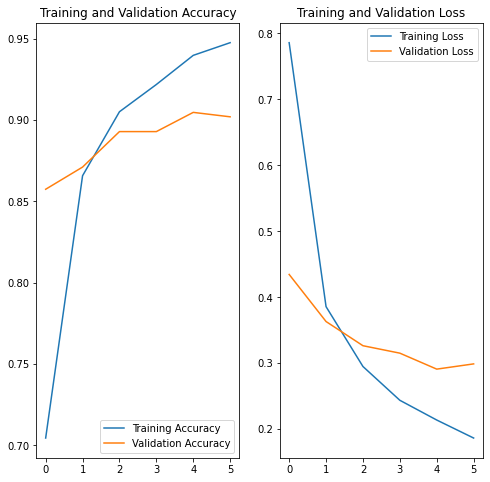

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

What is a bit curious here is that validation performance is better than training performance, right from the start to the end of execution.

One reason for this is that validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.

The bigger reason though is that we're reusing a large part of MobileNet which is already trained on Flower images. 

## TODO: Check Predictions

In the cell below get the label names from the dataset info and convert them into a NumPy array. Print the array to make sure you have the correct label names.

In [ ]:
class_names = np.array(dataset_info.features['label'].names)
print(class_names)


['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


### TODO: Create an Image Batch and Make Predictions

In the cell below, use the `next()` function to create an `image_batch` and its corresponding `label_batch`. Convert both the `image_batch` and `label_batch` to numpy arrays using the `.numpy()` method. Then use the `.predict()` method to run the image batch through your model and make predictions. Then use the `np.argmax()` function to get the indices of the best prediction for each image. Finally convert the indices of the best predictions to class names.

In [ ]:
image_batch, label_batch = next(iter(train_batches))



predicted_batch = model.predict(image_batch.numpy())
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)


['tulips' 'dandelion' 'tulips' 'roses' 'dandelion' 'dandelion'
 'sunflowers' 'daisy' 'tulips' 'roses' 'dandelion' 'dandelion' 'roses'
 'dandelion' 'tulips' 'tulips' 'roses' 'dandelion' 'dandelion' 'tulips'
 'tulips' 'tulips' 'daisy' 'dandelion' 'sunflowers' 'dandelion'
 'dandelion' 'dandelion' 'dandelion' 'sunflowers' 'dandelion' 'roses']


### TODO: Print True Labels and Predicted Indices

In the cell below, print the true labels and the indices of predicted labels.

In [ ]:
print("Labels:           ", label_batch.numpy())
print("Predicted labels: ", predicted_ids)

Labels:            [2 0 2 4 0 0 3 1 2 4 0 0 4 0 2 2 4 0 0 2 2 2 4 0 3 0 0 0 0 3 0 4]
Predicted labels:  [2 0 2 4 0 0 3 1 2 4 0 0 4 0 2 2 4 0 0 2 2 2 1 0 3 0 0 0 0 3 0 4]


## Plot Model Predictions

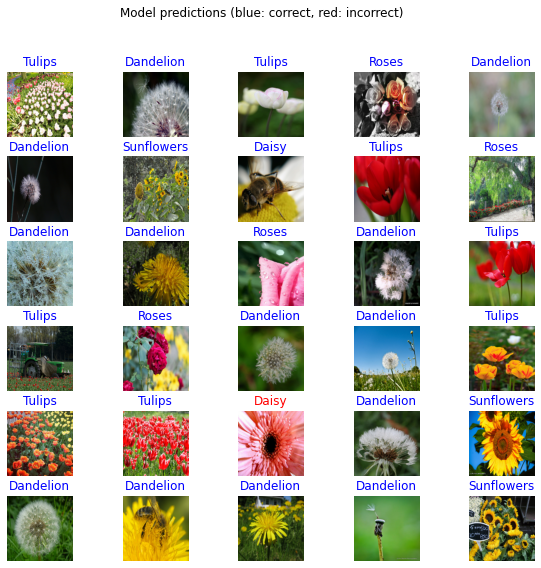

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

## TODO: Perform Transfer Learning with the Inception Model

Go to the [TensorFlow Hub documentation](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) and click on `tf2-preview/inception_v3/feature_vector`. This feature vector corresponds to the Inception v3 model. In the cells below, use transfer learning to create a CNN that uses Inception v3 as the pretrained model to classify the images from the Flowers dataset. Note that Inception, takes as input, images that are 299 x 299 pixels. Compare the accuracy you get with Inception v3 to the accuracy you got with MobileNet v2.

Create a Feature Extractor

In [ ]:
URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

Freeze the Pre-Trained Model

In [ ]:
feature_extractor.trainable = False

Attach a classification head

In [ ]:
model2 = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
EPOCHS = 6

model2.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history2 = model2.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 36s 281ms/step - loss: 0.7727 - accuracy: 0.7092 - val_loss: 0.4780 - val_accuracy: 0.8347
Epoch 2/6
81/81 [==============================] - 19s 237ms/step - loss: 0.4263 - accuracy: 0.8497 - val_loss: 0.4114 - val_accuracy: 0.8547
Epoch 3/6
81/81 [==============================] - 19s 236ms/step - loss: 0.3341 - accuracy: 0.8898 - val_loss: 0.3838 - val_accuracy: 0.8701
Epoch 4/6
81/81 [==============================] - 19s 236ms/step - loss: 0.2803 - accuracy: 0.9093 - val_loss: 0.3650 - val_accuracy: 0.8710
Epoch 5/6
81/81 [==============================] - 19s 236ms/step - loss: 0.2466 - accuracy: 0.9183 - val_loss: 0.3615 - val_accuracy: 0.8783
Epoch 6/6
81/81 [==============================] - 19s 237ms/step - loss: 0.2180 - accuracy: 0.9369 - val_loss: 0.3779 - val_accuracy: 0.8647


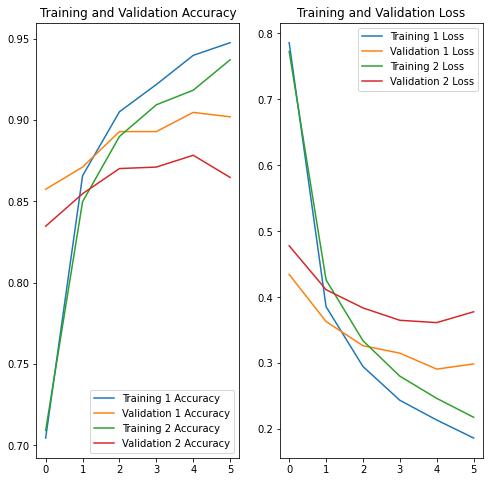

In [ ]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs_range = range(EPOCHS)


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training 1 Accuracy')
plt.plot(epochs_range, val_acc, label='Validation 1 Accuracy')
plt.plot(epochs_range, acc2, label='Training 2 Accuracy')
plt.plot(epochs_range, val_acc2, label='Validation 2 Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training 1 Loss')
plt.plot(epochs_range, val_loss, label='Validation 1 Loss')
plt.plot(epochs_range, loss2, label='Training 2 Loss')
plt.plot(epochs_range, val_loss2, label='Validation 2 Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()